[FUENTE DE INFORMACION: Estudio de Conjunto de datos desequilibrados para la detección de fraude con tarjeta de crédito- url: (https://www.kaggle.com/datasets/dark06thunder/credit-card-dataset?select=credit_dataset.csv)](https://www.kaggle.com/datasets/dark06thunder/credit-card-dataset?select=credit_dataset.csv)

<a id='Indice'></a>
## Índice
[Inicio ▲](#Indice)
1. [Estudiando el conjunto de Datos](#estudiando-los-datos)
    1. [Graficando las clases](#grafico-clases)
1. [Aplicando SMOTE](#aplicando-smote)
    1. [Evaluando Resultados - multiparametricos](#resultados-smote)

In [4]:
import pandas as pd 

import smote_variants as sv

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


## Preparacion de los datos

In [5]:
df = pd.read_csv('credit_dataset.csv')

In [6]:
df['GENDER'] = [0 if x == 'M' else 1 for x in df['GENDER']]
df['CAR'] = [1 if x == 'Y' else 0 for x in df['CAR']]
df['REALITY'] = [1 if x == 'Y' else 0 for x in df['REALITY']]
dummy_income_type = pd.get_dummies(df['INCOME_TYPE'], prefix='INC_TYPE', drop_first=True)
dummy_edu_type = pd.get_dummies(df['EDUCATION_TYPE'], prefix='EDU_TYPE', drop_first=True)
dummy_family_type = pd.get_dummies(df['FAMILY_TYPE'], prefix='FAM_TYPE', drop_first=True)
dummy_house_type = pd.get_dummies(df['HOUSE_TYPE'], prefix='HOUSE_TYPE', drop_first=True)
to_drop = ['Unnamed: 0', 'ID', 'FLAG_MOBIL', 'INCOME_TYPE',
           'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']
df.drop(to_drop, axis=1, inplace=True)

# Fusionar en un solo Dataframe
merged = pd.concat([df, dummy_income_type, dummy_edu_type, dummy_family_type, dummy_house_type], axis=1)
from sklearn.preprocessing import MinMaxScaler

# Escalar solo columnas que tengan valores mayores que 1
to_scale = [col for col in df.columns if df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Reemplazar las columnas originales con escalas
for col in scaled:
    merged[col] = scaled[col]
    
merged.head()
data = merged

In [7]:
X, y = data.drop(['TARGET'], axis=1), data['TARGET']

<a id='grafico-clases'></a>
## Grafico de Clases
[Inicio ▲](#Indice)

[Text(0, 0, '24712'), Text(0, 0, '422')]

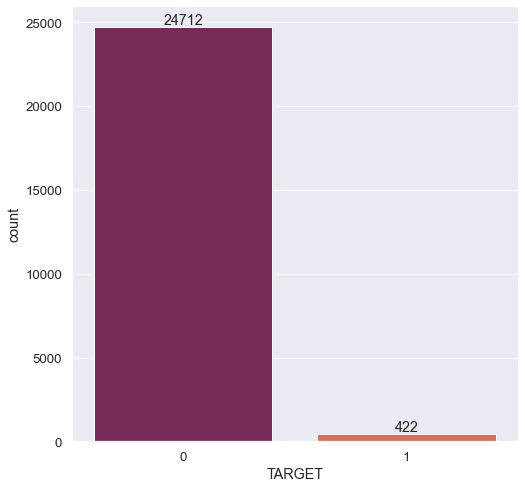

In [8]:
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize': [8, 8]}, font_scale=1.2)

ax =  sns.countplot(x='TARGET', data=data, palette='rocket')

abs_values = data['TARGET'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

In [9]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25)

<a id='aplicando-smote'></a>
## Aplicando SMOTE
[Inicio ▲](#Indice)

## Montaje de un pipeline

metricas: https://scikit-learn.org/stable/_sources/modules/model_evaluation.rst.txt

In [38]:
# oversampler= sv.SMOTE_TomekLinks()
# oversampler= sv.SMOTE_ENN()
oversampler= sv.SMOTE_IPF()
classifier= GaussianNB()
# classifier= RandomForestClassifier(random_state=42)
model= Pipeline([
                ('scale', StandardScaler()),
                ('clf', sv.OversamplingClassifier(oversampler, classifier))
            ])
model.fit(X_train, y_train)
param_grid= {'clf__oversampler':[sv.distance_SMOTE(proportion=0.2),
                                 sv.distance_SMOTE(proportion=0.3),
                                 sv.distance_SMOTE(proportion=0.4),
                                 sv.distance_SMOTE(proportion=0.5),
                                 sv.distance_SMOTE(proportion=0.6),
                                 sv.distance_SMOTE(proportion=0.7),
                                 sv.distance_SMOTE(proportion=0.8),
                                 sv.distance_SMOTE(proportion=0.9),
                                 sv.distance_SMOTE(proportion=1.0)]}
param_grid['clf__oversampler']


2022-05-14 23:33:04,052:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': DecisionTreeClassifier(random_state=2), 'random_state': None}")
2022-05-14 23:33:04,053:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Users\\\\FamiliaNatelloMedina\\\\AppData\\\\Roaming\\\\Python\\\\Python310\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-05-14 23:33:06,263:INFO:SMOTE_IPF: Removing 22 elements
2022-05-14 23:33:08,351:INFO:SMOTE_IPF: Removing 0 elements
2022-05-14 23:33:10,318:INFO:SMOTE_IPF: Removing 0 elements


In [39]:
scoring = {"recall": "recall", "precision": "precision", "f1" : "f1"}
grid= GridSearchCV(model, param_grid= param_grid, cv= 3, n_jobs= 1, verbose= 2, scoring= scoring, refit='recall' ) #probar con lista ['f1','recall','precision']
grid.fit(X_train, y_train)

2022-05-14 23:33:12,933:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-05-14 23:33:13,088:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.1s


2022-05-14 23:33:13,236:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-05-14 23:33:13,378:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.0s
[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.0s


2022-05-14 23:33:13,569:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.1s
[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.1s


2022-05-14 23:33:13,759:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-05-14 23:33:13,947:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.1s


2022-05-14 23:33:14,211:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.2s


2022-05-14 23:33:14,465:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.2s


2022-05-14 23:33:14,728:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.2s


2022-05-14 23:33:15,045:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.2s


2022-05-14 23:33:15,365:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.2s


2022-05-14 23:33:15,661:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.2s


2022-05-14 23:33:16,000:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.2s


2022-05-14 23:33:16,413:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.3s


2022-05-14 23:33:16,765:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.2s


2022-05-14 23:33:17,210:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.3s


2022-05-14 23:33:17,614:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.3s


2022-05-14 23:33:17,998:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.3s


2022-05-14 23:33:18,522:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.4s


2022-05-14 23:33:18,957:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.3s


2022-05-14 23:33:19,378:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.3s


2022-05-14 23:33:19,853:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.4s


2022-05-14 23:33:20,351:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.4s


2022-05-14 23:33:20,836:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.4s


2022-05-14 23:33:21,396:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.4s


2022-05-14 23:33:21,935:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.4s


2022-05-14 23:33:22,451:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   0.4s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        OversamplingClassifier(classifier=GaussianNB(),
                                                               oversampler=<smote_variants._smote_variants.SMOTE_IPF object at 0x0000017794331540>))]),
             n_jobs=1,
             param_grid={'clf__oversampler': [<smote_variants._smote_variants.distance_SMOTE object at 0x000001779421AFE0>,
                                              <smote_variants._smote_va...
                                              <smote_variants._smote_variants.distance_SMOTE object at 0x00000177943320E0>]},
             refit='recall',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'},
             verbose=2)

<a id='resultados-smote'></a>
## Evaluando los resultados de SMOTE
[Inicio ▲](#Indice)

In [40]:
datos = {'Recall' : grid.cv_results_['mean_test_recall'],
         'Precision' : grid.cv_results_['mean_test_precision'],
         'F1' : grid.cv_results_['mean_test_f1']}

df = pd.DataFrame(datos)

print(grid.get_params)
df

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        OversamplingClassifier(classifier=GaussianNB(),
                                                               oversampler=<smote_variants._smote_variants.SMOTE_IPF object at 0x0000017794331540>))]),
             n_jobs=1,
             param_grid={'clf__oversampler': [<smote_variants._smote_variants.distance_SMOTE object at 0x000001779421AFE0>,
                                              <smote_variants._smote_va...
                                              <smote_variants._smote_variants.distance_SMOTE object at 0x00000177943320E0>]},
             refit='recall',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'},
             verbose=2)>


,Recall,Precision,F1
0,0.155498,0.025942,0.040832
1,0.145726,0.021817,0.035944
2,0.207247,0.024890,0.041473
3,0.200806,0.023464,0.038210
4,0.204042,0.022475,0.036783
5,0.236405,0.021951,0.037994
6,0.217019,0.020932,0.035941
7,0.262358,0.020150,0.035973
8,0.255854,0.019432,0.034988
